In [12]:
%load_ext watermark
%watermark -p torch,lightning,torchvision

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
torch      : 2.7.0+cu128
lightning  : 2.5.2
torchvision: 0.22.0+cu128



In [13]:

import lightning as L
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
from lightning.pytorch.loggers import CSVLogger
import matplotlib.pyplot as plt
import numpy as np

from shared_utilities import LightningModel,Cifar10DataModule,plot_loss_and_acc

In [14]:

L.pytorch.seed_everything(123)

dm = Cifar10DataModule(batch_size=64, num_workers=4)
dm.prepare_data()
dm.setup()

Seed set to 123


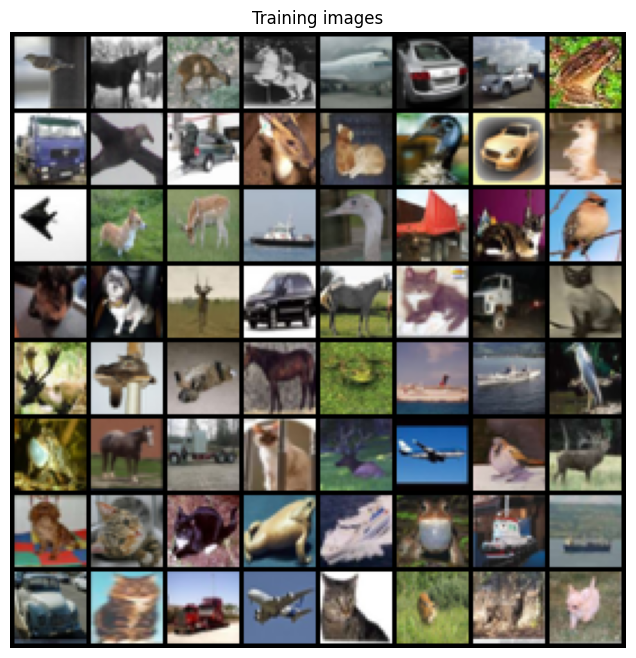

In [15]:
for images, labels in dm.train_dataloader():  
    break

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training images")
plt.imshow(np.transpose(torchvision.utils.make_grid(
    images[:64], 
    padding=2,
    normalize=True),
    (1, 2, 0)))
plt.show()

In [16]:
images[0].shape

torch.Size([3, 32, 32])

# Image Sampler

In [17]:

from torchvision import transforms

selfsupervised_transforms = transforms.Compose(
        [transforms.RandomResizedCrop(size=128),
         transforms.RandomHorizontalFlip(),
         transforms.RandomApply([transforms.ColorJitter(0.8 , 0.8, 0.8, 0.2)], p=0.8),
         transforms.RandomGrayscale(p=0.2),
         transforms.GaussianBlur(kernel_size=9, sigma=(0.1, 0.5)),
         transforms.ToTensor()]
)


class AugmentedImages:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, x):
        return [self.transforms(x), self.transforms(x)]

In [18]:
L.pytorch.seed_everything(123)

dm = Cifar10DataModule(batch_size=64, num_workers=4,
                       train_transform=AugmentedImages(selfsupervised_transforms),
                       test_transform=AugmentedImages(selfsupervised_transforms))
dm.prepare_data()
dm.setup()

Seed set to 123


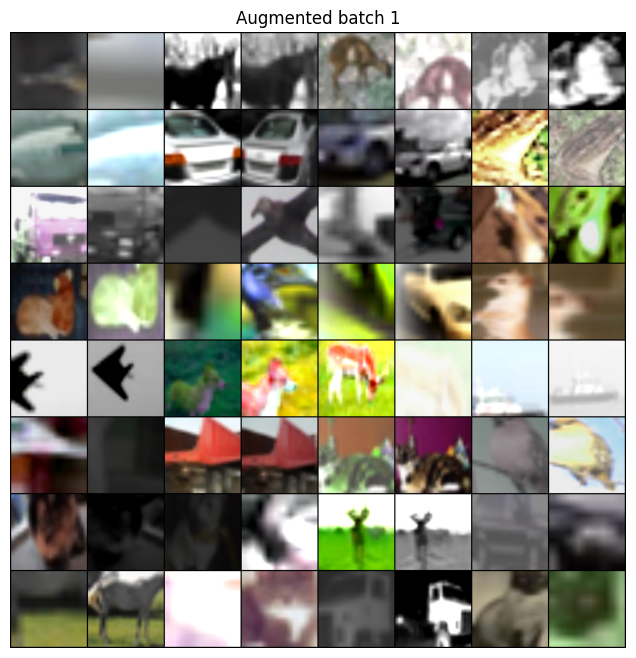

In [19]:
for images, labels in dm.train_dataloader():  
    break
    
paired_images = []
for i in range(32):
    paired_images.append(images[0][i])
    paired_images.append(images[1][i])
    
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Augmented batch 1")
plt.imshow(np.transpose(torchvision.utils.make_grid(
    paired_images[:64], 
    padding=2,
    normalize=True),
    (1, 2, 0)))
plt.show()

# Use 2 fully connected layers

In [22]:
# We want to assume and collect only the images and labes and fine tune it to classification tasks. 

pytorch_model = torch.hub.load('pytorch/vision', 'resnet18', weights=None)
pytorch_model.fc = torch.nn.Sequential(
    nn.Linear(512,512),
    nn.ReLU(),
    nn.Linear(512,216) # We will get the embeddings !! not not classes to further finetune for specific class!! 
)


Using cache found in /home/zeus/.cache/torch/hub/pytorch_vision_main


# Info NCE loss

In [23]:
# Inspired by https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial17/SimCLR.ipynb


def info_nce_loss(feats, temperature, mode="train"):

    # Calculate cosine similarity
    cos_sim = F.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
    
    # Mask out cosine similarity to itself
    self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
    cos_sim.masked_fill_(self_mask, -9e15)
    
    # Find positive example -> batch_size//2 away from the original example
    pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
    
    # InfoNCE loss
    cos_sim = cos_sim / temperature
    nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
    nll = nll.mean()
    
    comb_sim = torch.cat(
        [cos_sim[pos_mask][:, None], cos_sim.masked_fill(pos_mask, -9e15)],  # First position positive example
        dim=-1,
    )
    sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)

    return nll, sim_argsort

In [24]:
class LightningModelSimCLR(L.LightningModule):
    def __init__(self, model, learning_rate, temperature):
        super().__init__()

        self.learning_rate = learning_rate
        self.temperature = temperature
        self.model = model

        self.save_hyperparameters(ignore=["model"])

        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):

        ### NEW ###
        # images, true_labels = batch
        images, _ = batch
        images = torch.cat(images, dim=0)
        transformed_feats = self(images)

        loss, sim_argsort = info_nce_loss(transformed_feats, mode="train", temperature=self.temperature)
        self.log("train_loss", loss)
        self.log("train_acc", (sim_argsort < 5).float().mean()) # we are looking at top 5 exammples if it contains the image
        
        return loss

    def validation_step(self, batch, batch_idx):

        ### NEW ###
        # images, true_labels = batch
        images, _ = batch
        images = torch.cat(images, dim=0)
        transformed_feats = self(images)

        loss, sim_argsort = info_nce_loss(transformed_feats, mode="val", temperature=self.temperature)
        self.log("val_loss", loss)
        self.log("val_acc", (sim_argsort < 5).float().mean())
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

In [27]:
%%capture --no-display

L.seed_everything(123)

dm = Cifar10DataModule(batch_size=256, num_workers=4,
                       train_transform=AugmentedImages(selfsupervised_transforms),
                       test_transform=AugmentedImages(selfsupervised_transforms))

lightning_model = LightningModelSimCLR(model=pytorch_model, temperature=0.07, learning_rate=0.0005)

trainer = L.Trainer(
    fast_dev_run=1,
    max_epochs=50,
    accelerator="auto",
    devices=1,
    logger=CSVLogger(save_dir="logs/", name="my-model"),
    deterministic=True,
)

Seed set to 123
ðŸ’¡ Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.


In [28]:

trainer.fit(model=lightning_model, datamodule=dm)


  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | ResNet             | 11.5 M | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | val_acc   | MulticlassAccuracy | 0      | train
3 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
11.5 M    Trainable params
0         Non-trainable params
11.5 M    Total params
46.200    Total estimated model params size (MB)
74        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1` reached.


In [ ]:

plot_loss_and_acc(trainer.logger.log_dir)

In [ ]:
trainer.test(model=lightning_model, datamodule=dm)

In [ ]:
torch.save(pytorch_model.state_dict(), "simclr-resnet18.pt")